In [1]:
# This will be the next generation of model. The model will aim to include all relief pitchers as well as standardising the data.
# This will model will fork from model v2 and not v3. Normalised did not provide favourable results requiring further reanalysis. 
# Features: Batters: Pitchers:
# Version: 1.0

In [59]:
%load_ext autoreload
%autoreload 2
import import_ipynb
from sklearn import svm
from pymysql import connect
from sys import path
from pathlib import Path
path.append('../../../') 
from BaseballAnalytics.bin.app_utils.queries_vTwo import Queries as Qu_VTwo
from BaseballAnalytics.bin.app_utils.consolidation.consolidating_features import Feature_Consolidater, Feature_Pack
from BaseballAnalytics.bin.app_utils.queries import Queries as Qu
from BaseballAnalytics.bin.app_utils.common_help import Log_Helper
from pickle import dump, load
from traceback import print_exc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Connect to the database.
data_locs = Path(r"C:\Users\micha\Documents\GitHub\BaseballAnalytics\source_data\model_data\model_v2")      # The location of the past queries.
conn = connect(host="localhost", user="root", passwd="praquplDop#odlg73h?c", db="baseball_stats_db")
qu_vTwo = Qu_VTwo(conn)
qu = Qu(conn)

In [4]:
# Get all the game ids with the relevent information attributed to those id. Ensure to get games past May 15.
# The games are returned from earliest played to most recent.
# The 0 at the end indicates a home team victory.
game_outcomes = qu_vTwo.get_game_outcomes(day=15, month=5)            
game_outcomes = game_outcomes[200:]
game_outcomes[0:5]

[('LAN199005020', 1990, 2, 5, 6, 2, 'LAN', 'PIT', 0),
 ('MON199005020', 1990, 2, 5, 1, 8, 'MON', 'ATL', 1),
 ('NYA199005020', 1990, 2, 5, 0, 2, 'NYA', 'OAK', 1),
 ('NYN199005020', 1990, 2, 5, 5, 0, 'NYN', 'CIN', 0),
 ('PHI199005020', 1990, 2, 5, 14, 4, 'PHI', 'HOU', 0)]

In [5]:
# Get the outcomes of all the games.
game_outcomes_all = qu_vTwo.get_game_outcomes()
len(game_outcomes_all)

70101

In [6]:
# Fetch the players, pitchers, and offensive features from all the games.
pitchers_pickle = 'game_pitchers.pickle'
all_pitchers = qu_vTwo.get_pitchers_in_all_games(data_locs / pitchers_pickle)
qu_vTwo.unpack_pitchers(all_pitchers)

An Event ['langm001', '0ANA199704020']
Num Events 46
Num Games 162
Num Years 23
Num Teams 33


In [7]:
# Gather all the relief pitchers. -- POSSIBLE EXCEPTION (NOT ALL GAMES INCLUDED, GAMES MAY BE MISSING DUE TO COMPLETE GAMES)
relief_pitchers = qu_vTwo.get_relief_pitchers(all_pitchers, 25)
print("Games accounted for: {}".format(len(relief_pitchers)))
for game in relief_pitchers:
    print(game)
    print(relief_pitchers[game])
    break

The number of relievers to contian: 3
Games accounted for: 69649
ANA199704020
{'ANA': ['may-d002', 'perct001', 'jamem001'], 'BOS': ['henrb001', 'mahop001', 'sloch001']}


In [8]:
# Gather all the starting pitchers.
starting_pitchers = qu_vTwo.get_starting_pitchers(all_pitchers)
print("Games accounted for: {}".format(len(starting_pitchers)))
for game in starting_pitchers:
    print(game)
    print(starting_pitchers[game])
    break

Games accounted for: 70101
ANA199704020
{'ANA': 'langm001', 'BOS': 'gordt001'}


In [9]:
# Gather all the pitching features from the database.
pitching_feat_pickle = 'raw_pitching_features.pickle'
pitching_features = qu_vTwo.get_all_pitching_features(data_locs / pitching_feat_pickle)
for player_id in pitching_features:
    print(player_id)
    for i, game in enumerate(pitching_features[player_id]):
        print(game)
        if i > 1: break
    break

ackej001
['TEX199004090', 1.0, 2.02, 0.0]
['TOR199004120', 1.5, 1.261, 0.0]
['KCA199004150', 1.333, 2.861, 0.667]


In [10]:
# Acquire all the batters from the database.
batters_pickle = 'game_players.pickle'
all_batters = qu_vTwo.get_batters(data_locs / batters_pickle)
for game_id in all_batters:
    print(game_id)
    for i, event in enumerate(all_batters[game_id]):
        print(event)
        if i > 6: break
    break

ANA199704020
['garcn001', 0, '0ANA199704020']
['pembr001', 0, '10ANA199704020']
['haseb001', 0, '11ANA199704020']
['macks001', 0, '12ANA199704020']
['holld001', 1, '13ANA199704020']
['andeg001', 1, '14ANA199704020']
['murre001', 1, '15ANA199704020']
['leyrj001', 1, '16ANA199704020']


In [11]:
# Acquire all the batters features from the database.
offensive_feat_pickle = 'raw_offensive_features.pickle'
offensive_features = qu_vTwo.get_all_offensive_features(data_locs / offensive_feat_pickle)
for player_id in offensive_features:
    print(player_id)
    for i, game in enumerate(offensive_features[player_id]):
        print(game)
        if i > 1: break
    break

bainh001
['TEX199004090', 0.25, 1.0]
['TOR199004100', 0.25, 0.625]
['TOR199004110', 0.5, 0.625]


In [44]:
# Get the n game rolling average winning perct.
fc = Feature_Consolidater()
winning_pct = fc.get_win_pct(game_outcomes_all, 15)   
for num, i in enumerate(winning_pct):
    print(i)
    print(winning_pct[i])
    if num > 1:
        break

BOS199004090
{'BOS': 0.0, 'DET': 0.0}
CAL199004090
{'CAL': 0.0, 'SEA': 0.0}
CHA199004090
{'CHA': 0.0, 'MIL': 0.0}


In [47]:
features_pickle = data_locs / 'game_features.pickle'
fp = Feature_Pack(game_outcomes, winning_pct, all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features)
X, Y = fc.get_all_game_features(fp, features_pickle, normalise=False, get_again_flag=True)
print("\nSample from X:\n")
for num, i in enumerate(X):
    print(i)
    if num > 0:
        break
print("\nSample from Y:\n")
for num, i in enumerate(Y):
    print(i)
    if num > 0:
        break  

Progress: |||||||||||||||||||||||||||||||||||||||||||||||||||| 100.0% Complete

Sample from X:

[4.25, 1.263, 2.25, 0.45, 0.3125, 0.29, 0.21666, 0.445, 0.55333, 0.29833, 0.39334, 0.18333, 0.18333, 0.36166, 0.37, 0.38334, 0.43334, 0.325, 0.38334, 0.25, 0.125, 1.0, 1.748, 1.6, 0.8, 2.275, 1.3, 0.6, 1.117, 1.3, 0.5333333333333333, 4.5, 1.01, 1.75, 0.28333, 0.34833, 0.28999, 0.35, 0.28333, 0.25, 0.24, 0.41, 0.51667, 0.75833, 0.25, 0.26851, 0.39667, 0.48833, 0.29667, 0.225, 0.0, 0.0, 0.2, 1.488, 0.6, 0.3, 2.221, 1.2, 0.8, 1.118, 0.4, 0.7333333333333333]
[4.5, 1.1, 1.75, 0.355, 0.35667, 0.33333, 0.32666, 0.22222, 0.16667, 0.32167, 0.45, 0.54761, 0.45, 0.05833, 0.08333, 0.1111, 0.1111, 0.38333, 0.47499, 0.5, 0.9, 0.6, 2.587, 1.2, 0.4, 3.429, 1.7, -1.0, -1.0, -1.0, 0.6, 5.0, 1.555, 2.5, 0.215, 0.40166, 0.075, 0.08333, 0.15, 0.225, 0.265, 0.43, 0.39166, 0.46665, 0.12037, 0.09259, 0.33333, 0.41665, 0.32833, 0.42833, 0.0, 0.0, 0.4, 1.552, 1.4, 1.4, 2.431, 1.1, 3.2, 2.067, 3.1, 0.26666666666666666

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [49]:
# Split the data for modelling.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [50]:
sm = svm.SVC(kernel='linear', C=0.01, verbose=True).fit(X_train, y_train)
sm.score(X_test, y_test)

[LibSVM]

0.5511611398438292

In [51]:
rf = RandomForestClassifier(max_depth=15, random_state=0, verbose=True).fit(X_train, y_train)
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.5495385863502688

In [52]:
lr = LogisticRegression(max_iter=5000, verbose=True).fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_, lr.intercept_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
0.5559273907311632
[[-8.52594675e-02  3.09867535e-02  3.97342361e-02  1.64132000e-01
  -4.94524287e-02 -2.81103379e-01  8.36786017e-03 -4.99552139e-02
  -4.54306550e-02 -2.95675806e-01  9.79336003e-03 -1.50134362e-01
  -5.46208572e-03  1.74999206e-02 -1.73432942e-02 -4.06620976e-01
   2.18806926e-01 -9.41446172e-02  1.27968416e-01  2.22072736e-02
  -1.94522912e-01  2.57163620e-03 -5.91272649e-04  7.85939194e-03
  -1.16141872e-02  7.85817312e-03  3.00862225e-02 -2.29218721e-02
  -4.51152050e-03  1.50864122e-02 -4.25280865e-01  8.81010516e-02
  -3.95647894e-02 -5.31851590e-02  1.24313869e-01  5.83516173e-02
  -1.09329023e-01  8.00245349e-02  1.76135895e-01 -9.41443333e-03
   1.34150731e-01  7.59133562e-02  4.75925347e-01 -1.09667669e-01
   1.66290631e-01  1.00373918e-02  6.20027175e-02  5.56535746e-02
   2.62363406e-01 -9.00723809e-02  4.98529826e-02  9.81342286e-02
   2.12729581e-02 -3.10819192e-04 -1.15432

In [53]:
mlp = MLPClassifier(random_state=1, max_iter=2000, verbose=True).fit(X_train, y_train)
mlp.score(X_test, y_test)

Iteration 1, loss = 0.69159209
Iteration 2, loss = 0.68706932
Iteration 3, loss = 0.68587158
Iteration 4, loss = 0.68503729
Iteration 5, loss = 0.68464654
Iteration 6, loss = 0.68412854
Iteration 7, loss = 0.68475740
Iteration 8, loss = 0.68438625
Iteration 9, loss = 0.68295238
Iteration 10, loss = 0.68326414
Iteration 11, loss = 0.68349499
Iteration 12, loss = 0.68232731
Iteration 13, loss = 0.68245982
Iteration 14, loss = 0.68221673
Iteration 15, loss = 0.68123858
Iteration 16, loss = 0.68054694
Iteration 17, loss = 0.68120802
Iteration 18, loss = 0.68028311
Iteration 19, loss = 0.68006169
Iteration 20, loss = 0.67973859
Iteration 21, loss = 0.67990181
Iteration 22, loss = 0.67899882
Iteration 23, loss = 0.67880008
Iteration 24, loss = 0.67794927
Iteration 25, loss = 0.67779862
Iteration 26, loss = 0.67761593
Iteration 27, loss = 0.67750132
Iteration 28, loss = 0.67647684
Iteration 29, loss = 0.67685027
Iteration 30, loss = 0.67621561
Iteration 31, loss = 0.67546223
Iteration 32, los

0.5275327045938546

Confusion matrix, without normalization
[[3773 1444]
 [2935 1709]]
Normalized confusion matrix
[[0.72321257 0.27678743]
 [0.63199828 0.36800172]]


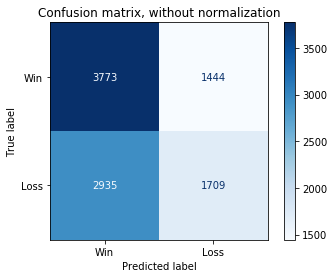

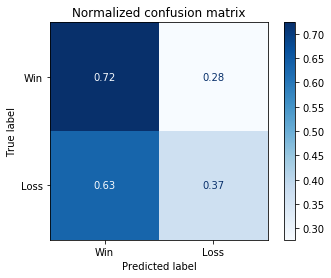

In [54]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Win', 'Loss'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [55]:
# Use cross validation to get a better idea of the models success.
from sklearn.model_selection import cross_val_score
lr_cv = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr_cv, X, Y, cv=5)
print(cv_scores)

[0.54316574 0.56035597 0.55343424 0.55617251 0.55492165]


In [56]:
rf_cv = RandomForestClassifier(max_depth=15, random_state=0, verbose=True)
cv_scores = cross_val_score(rf_cv, X, Y, cv=5)
print(cv_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

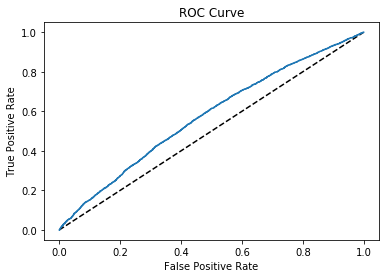

In [57]:
# Build an ROC for the Logistical Regression
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [58]:
# Utilise xgboost
import xgboost
import numpy as np
xg_cl = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123).fit(np.asarray(X_train, dtype=np.float32), np.asarray(y_train, dtype=np.float32))
xg_cl.score(np.asarray(X_test, dtype=np.float32), np.asarray(y_test, dtype=np.float32))

0.5516681878105669

In [ ]:
# Repeat the process above but with the Normalised Features.
features_pickle = data_locs / 'game_features_normalised.pickle'
fp = Feature_Pack(game_outcomes, winning_pct, all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features)
X, Y = fc.get_all_game_features(fp, features_pickle, normalise=True, get_again_flag=True)
print("\nSample from X:\n")
for num, i in enumerate(X):
    print(i)
    if num > 0:
        break
print("\nSample from Y:\n")
for num, i in enumerate(Y):
    print(i)
    if num > 0:
        break  

In [ ]:
# Split the data for modelling.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [ ]:
sm = svm.SVC(kernel='linear', C=0.01, verbose=True).fit(X_train, y_train)
sm.score(X_test, y_test)

In [ ]:
rf = RandomForestClassifier(max_depth=15, random_state=0, verbose=True).fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
lr = LogisticRegression(max_iter=5000, verbose=True).fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
mlp = MLPClassifier(random_state=1, max_iter=2000, verbose=True).fit(X_train, y_train)
mlp.score(X_test, y_test)

In [ ]:
xg_cl = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123).fit(np.asarray(X_train, dtype=np.float32), np.asarray(y_train, dtype=np.float32))
xg_cl.score(np.asarray(X_test, dtype=np.float32), np.asarray(y_test, dtype=np.float32))